# RBF Regression on Boston hosting Dataset
### Charis Filis
### Academic-id : 9449 

Add needed dependencies

In [70]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [71]:
import tensorflow as tf
# Import  tensorflow.keras basic NNet modules for the RBF output layer
from tensorflow.keras import layers,models
from tensorflow.keras import initializers
# Import tensorflow.keras backend for any tensor operations
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import boston_housing
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import addons for RSqure metric
import tensorflow_addons as tfa
from tensorflow.keras.metrics import RootMeanSquaredError
# Import pairwise metric 
from sklearn.metrics import pairwise
# Import KMeans algorithm in case the custom one does not work properly
from sklearn.cluster import KMeans
# Import numpy for array and numeric operations
import numpy as np

In [72]:
(x_train, y_train),(x_test, y_test) = boston_housing.load_data(test_split=0.25)


#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)
print(x_train[1], y_train[1])
# get per-feature statistics (mean,standard deviation ) from the training set in order to make normalization
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train,axis=0)
x_train = (x_train-train_mean)/train_std
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print("Training data shape:",x_train.shape)
print("Training y train shape", y_train.shape)
print("Testing data shape:",x_test.shape)


[2.1770e-02 8.2500e+01 2.0300e+00 0.0000e+00 4.1500e-01 7.6100e+00
 1.5700e+01 6.2700e+00 2.0000e+00 3.4800e+02 1.4700e+01 3.9538e+02
 3.1100e+00] 42.3
Number of original training examples: 379
Number of original test examples: 127
Training data shape: (379, 13)
Training y train shape (379,)
Testing data shape: (127, 13)


R squared metric custom made 

In [104]:
def R2(test_val, pred_val):
    SS_res = K.sum(K.square(test_val-pred_val))
    SS_tot = K.sum(K.square(test_val-K.mean(test_val)))
    return (1 - SS_res/(SS_tot+K.epsilon()))

Model 1 compute centers and sigma and Number of Kernels = 0.1 Ntrain

In [137]:
from scipy.spatial.distance import pdist
# Variance of each kernel
from cmath import sqrt
# num of kernels in hidden layer = number of inputs = number of nodes of  RBF layer
n_centers = int(0.1*x_train.shape[0])
print(n_centers)
def computeSigma(n_centers):
        km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
        centers = km.cluster_centers_
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
        return sigma
   
sigma = computeSigma(n_centers)
print(sigma)

37
tf.Tensor(1.3053014, shape=(), dtype=float32)


In [126]:
from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_
        

Create RBF layer or RBF kernel would be described

In [139]:
from tensorflow.keras.layers import Layer
from keras import backend as K
from keras.initializers import RandomNormal, Initializer, Constant
import numpy as np

class RBFLayer(Layer):
    """
        RBF Layer applying Gaussian Kernel
        # Arguments
        units := number of neurons
        initializer := weight or centroid initializer for each neuron Kmean is used
        b := thresholds of output layer
    """
    def __init__(self,units,sigmaInit,initializer=None,b=1.0,**kwargs):
        self.init_betas = b
        self.units = units
        self.sigmaInit = sigmaInit
        if not initializer:
            self.initializer = RandomNormal(mean = 0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        # I initialize the weights of rbf layer with kmeans 
        self.W = self.add_weight(name='W',
                                 shape=(self.units,input_shape[1]),
                                 initializer=self.initializer,
                                 trainable=True)
        self.b  = self.add_weight(shape=(self.units,),
                            initializer=Constant(value=self.init_betas),
                            trainable=True)

        super(RBFLayer,self).build(input_shape)
    
    # radial basis function
    def call(self, inputs):
        diff = K.expand_dims(self.W) 
        H = K.transpose(diff - K.transpose(inputs)) 
        # take L2 norm for the exponent of the radial basis function
        l2 = K.sum(K.pow(H,2), axis=1)
        res = K.exp((-self.b * l2)/(2*(self.sigmaInit**2)))     
        return res

    def compute_output_shape(self, input_shape):
        return ( self.units,input_shape[0])
    
    # define get_config function to use model_from_jason
    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'units': self.units
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
                                 
        
    
    

In [ ]:
# RBF layer optimiztion run afterwards
def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))
def run_optimization(rbf_layer):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        loss = mean_square(model_out.predict(x_train), y_train)
        # Compute gradients.
        gradients = g.gradient(loss, [rbf_layer.W, rbf_layer.b])
        # Update W and b following gradients.
        optimizer.apply_gradients(zip(gradients, [rbf_layer.W, rbf_layer.b]))
run_optimization(rbf_layer=rbf_layer)

### Create 1st model builder function

Train output layer

In [141]:
model_out = models.Sequential()
rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
model_out.add(rbf_layer)

# Output Layer
model_out.add(layers.Dense(128,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))

# Make the linear tranformation layer on the output layer
model_out.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
model_out.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss='mean_squared_error',
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
model_out.summary()
history_1 = model_out.fit(x_train,y_train,epochs=100,batch_size=48,validation_split=0.2,verbose=1)


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_53 (RBFLayer)     (None, 37)                518       
                                                                 
 dense_58 (Dense)            (None, 128)               4864      
                                                                 
 dense_59 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 34ms/step - loss: 532.3644 - root_mean_squared_error: 23.0730 - R2: -10.5749 - val_loss: 695.2817 - val_root_mean_squared_error: 26.3682 - val_R2: -6.0545
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 434.3736 - root_mean_squared_error:

Model 1


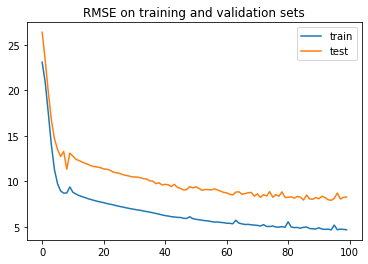

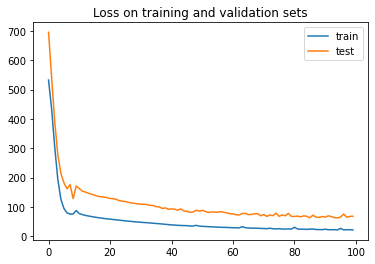

In [142]:

print("Model 1")
# Plot RMSE
plt.figure(1)
plt.plot(history_1.history['root_mean_squared_error'],label='train')
plt.plot(history_1.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
# Plot loss
plt.figure(2)
plt.plot(history_1.history['loss'],label='train')
plt.plot(history_1.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

### Reconsideration
At this point i realize that keras models are not working well with custom made layers such as the one RBF I made. After research and communication with a professor,
I came to an understanding that RBF layer is just a kernel that could be applied to data and the we can instantly proceed adn push that data to the output layer.
So because I have no time for debugging im using sklearn to create a custom rbf kernel from pairwise lib and I apply this to a specific number of data inputs in order to have the correct. Last but not least I want to point out that there are implementation of creating rbf Layers that work with keras and I found some but they are not quite effective thats why I made the training epochs 1000

### Case 2  Model 2 compute centers and sigma and Number of Kernels = 0.5 Ntrain

In [134]:
from scipy.spatial.distance import pdist
# Variance of each kernel
from cmath import sqrt
# num of kernels in hidden layer = number of inputs = number of nodes of  RBF layer
n_centers = int(0.5*x_train.shape[0])
print(n_centers)
def computeSigma(n_centers):
        km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
        centers = km.cluster_centers_
        dists = pdist(centers, metric='euclidean')
        d_max = np.amax(dists)
        sigma = d_max / tf.math.sqrt(2*float(centers.shape[0])) 
        return sigma
   
sigma = computeSigma(n_centers)
print(sigma)

189
tf.Tensor(0.68750733, shape=(), dtype=float32)


### Create Model 2 and train it 

In [135]:
model_2 = models.Sequential()
rbf_layer = RBFLayer(units = n_centers,sigmaInit=sigma,initializer=InitCentersKMeans(x_train),input_shape=(x_train.shape[1],))

rbf_out_shape = rbf_layer.compute_output_shape((x_train.shape[1],))
model_2.add(rbf_layer)

# Output Layer
model_2.add(layers.Dense(128,activation='relu',input_shape=rbf_out_shape,
                            kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))

# Make the linear tranformation layer on the output layer
model_2.add(layers.Dense(1,activation='relu',
                kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
model_2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])
model_2.summary()
history_2 = model_out.fit(x_train,y_train,epochs=100,batch_size=48,validation_split=0.2,verbose=1)

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_50 (RBFLayer)     (None, 189)               2646      
                                                                 
 dense_52 (Dense)            (None, 128)               24320     
                                                                 
 dense_53 (Dense)            (None, 1)                 129       
                                                                 
Total params: 27,095
Trainable params: 27,095
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 12ms/step - loss: 22.7518 - root_mean_squared_error: 4.7699 - R2: 0.6830 - val_loss: 69.3029 - val_root_mean_squared_error: 8.3248 - val_R2: 0.4251
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 22.6272 - root_mean_squared_error: 4.756

### Print Results

Model 2


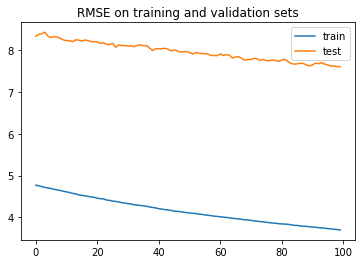

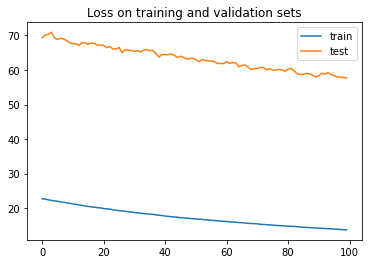

In [136]:
print("Model 2")
# Plot RMSE
plt.figure(3)
plt.plot(history_2.history['root_mean_squared_error'],label='train')
plt.plot(history_2.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()
# Plot loss
plt.figure(4)
plt.plot(history_2.history['loss'],label='train')
plt.plot(history_2.history['val_loss'],label='test')
plt.legend()
plt.title('Loss on training and validation sets')
plt.show()

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

# apply kmeans to find initial centers
km = KMeans(n_clusters=n_centers, init='random', verbose=0).fit(x_train)
centers = km.cluster_centers_
# typecast 1/2sigma to float vector in order to be applied to kernel
x_rbf_out = rbf_kernel(x_train,Y =centers, gamma = np.float32( 1/(2*sigma)) )


### Create output layer model builder function

In [ ]:
def output_layer_builder():
    model_out = models.Sequential()
    # RBF layer kernel applied to data as transformation
    # Output Layer
    model_out.add(layers.Dense(128, activation='relu', input_shape=(x_rbf_out.shape[1],),
                         kernel_initializer=initializers.RandomNormal(mean = 0,stddev=0.4)))
    
    # Make the linear tranformation layer on the output layer
    model_out.add(layers.Dense(1,activation='relu',
                  kernel_initializer= initializers.RandomNormal(mean = 0,stddev=0.4)))
    model_out.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.RootMeanSquaredError(), R2])

Train Model 1

In [ ]:

model_1 = output_layer_builder()
history_1 = model_1.fit(x_rbf_out,y_train,epochs=100,batch_size=48,validation_split=0.2,verbose=1)

# Plot RSQ
plt.figure(1)
plt.plot(history.history['RSquare'])





# Plot RMSE
plt.figure(1)
plt.plot(history.history['root_mean_squared_error'],label='train')
plt.plot(history.history['val_root_mean_squared_error'],label='test')
plt.legend()
plt.title('RMSE on training and validation sets')
plt.show()

AttributeError: 'NoneType' object has no attribute 'fit'